In [56]:
# TODO: これまでやってきた取り組みを遡ってスコア計測したい
# スコア計測して取り組みとスコアの推移を記録したら発表に使えるかも

In [57]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabelSequence, crf_label
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [59]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabelSequence.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabelSequence.from_abbreviation, data_test))

In [60]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [61]:
y_pred = model.predict(X_test)

In [62]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.7703898947071977

In [63]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] != crf_label.NG:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = (np.array(y_pred[i]) == y_test[i]).mean()
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

0.875 ko re su po N de N su -> ko re
1.000 a ge N su to u i N do -> a ge N su to
0.667 ko mi Q ku ma a ke Q to -> ko mi ma a
1.000 ru u pu shu u to -> ru u pu
0.667 pa wa a su te a ri N gu -> pa wa a
1.000 fu ro Q ku ko o to -> fu ro Q ku
1.000 pa N ji i ja N pu -> pa N ji i
0.571 ri a ru fu re N do -> ri a ru
0.000 shi i zu N o fu -> shi i zu N
1.000 hi su te ri i -> hi su
0.000 sa u N do e fe ku to -> sa u N do
1.000 ha a do ko N ta ku to re N zu -> ha a do ko N ta ku to
0.875 ma ku ro su ko pi Q ku -> ma ku
1.000 a ri a N ro ke Q to -> a ri a N
1.000 de mo N su to re e sho N -> de mo
1.000 da bu ru be Q do -> da bu ru
0.500 ko N sa a to mi su to re su -> ko N sa a to
0.500 da N su do ri ru -> da N su
0.700 pu ro gu re Q shi pu ro Q ku -> pu ro gu re Q shi pu
1.000 ho o mu be e su -> ho o mu
1.000 me do re e ri re e -> me do re e
0.833 te N pu re e to -> te N
1.000 te ro ri zu mu -> te ro
0.111 bu ru ga a ni N ra i N -> bu ru ga a ni N
1.000 a na a ki su to -> a na
0.364 shi i mu re 

In [64]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.5196850393700787


In [65]:
score_list.mean()

0.7757242647990679

(array([ 18.,   3.,   2.,  10.,   7.,  18.,  25.,  16.,  22., 133.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

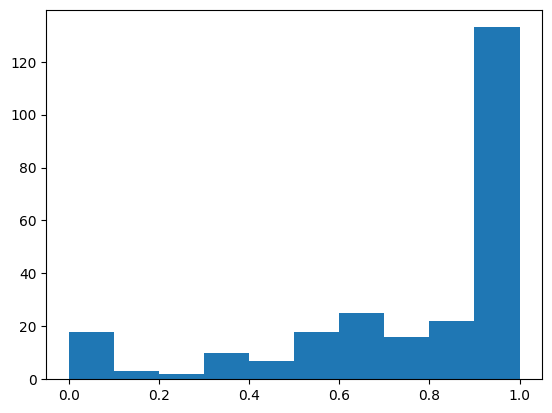

In [66]:
plt.hist(score_list, bins=10)